In [1]:
import Pkg; 

if split(pwd(),"/")[end] == "utility"
    cd(joinpath(@__DIR__, "../../../MorphoMolMonteCarlo/"))
    Pkg.activate("Project.toml")
end

using MorphoMol

if split(pwd(), "/")[end] == "MorphoMolMonteCarlo"
    cd(joinpath(@__DIR__, "../MMMCNotebooks/"))
    Pkg.activate("Project.toml")
end

using PyCall
using JLD2
using LinearAlgebra
using Rotations
using CairoMakie

  Activating project at `~/Doktor/Code/MMMC/MorphoMolMonteCarlo`
Precompiling MorphoMol
  ✓ MorphoMol
  1 dependency successfully precompiled in 2 seconds. 238 already precompiled.
  Activating project at `~/Doktor/Code/MMMC/MMMCNotebooks`
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
Precompiling DistributionsTestExt
  ✓ Distributions → DistributionsTestExt
  1 dependency successfully precompiled in 6 seconds. 43 already precompiled.
[ Info: Precompiling DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019]
┌ Warning: Module Distributions with build ID fafbfcfd-e4d5-fbc3-0000-54f6b99da324 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019].


In [2]:
pyimport("sys").executable

"/Users/ivanspirandelli/Doktor/Code/Notebooks/oineus_venv/bin/python3"

In [3]:
py"""
import oineus as oin
import numpy as np
import torch
import diode

def calculate_total_persistence(points):
    points = np.asarray(points)
    simplices = diode.fill_alpha_shapes(points)
    fil = oin.Filtration_double([oin.Simplex_double(s[0], s[1]) for s in simplices])
    # no cohomology
    dualize = False
    # create VRU decomposition object, does not perform reduction yet
    dcmp = oin.Decomposition(fil, dualize)
    rp = oin.ReductionParams()
    rp.compute_u = rp.compute_v = True
    rp.n_threads = 1
    # perform reduction
    dcmp.reduce(rp)
    # now we can acess V, R and U
    # indices are sorted_ids of simplices == indices in fil.cells()
    V = dcmp.v_data
    simplices = fil.simplices()
    dgms = dcmp.diagram(fil, include_inf_points=False)
    dim=1
    dgm_dim = dcmp.diagram(fil, include_inf_points=False)[dim]
    return sum([e[1] - e[0] for e in dgm_dim])
"""

function calculate_total_persistence(points::Vector{Vector{Float64}})
    py"calculate_total_persistence"(points)
end

calculate_total_persistence (generic function with 1 method)

In [4]:
perturb_all(x, Σ) = x .+ (randn(length(x)) .* Σ)

function perturb_single_randomly_chosen(x, σ_r, σ_t)
    x_cand = deepcopy(x)
    i  = rand(0:(length(x)÷6)-1)
    x_cand[(i*6)+1:(i*6)+6] = x_cand[(i*6)+1:(i*6)+6] .+ randn(6) .* [σ_r, σ_r, σ_r, σ_t, σ_t, σ_t]
    x_cand
end

function solvation_free_energy_and_measures_in_bounds(x::Vector{Float64}, template_mol::Matrix{Float64}, radii::Vector{Float64}, rs::Float64, prefactors::AbstractVector, overlap_jump::Float64, overlap_slope::Float64, persistence_weight::Float64, bounds::Float64, delaunay_eps::Float64)
    if any(0.0 >= e || e >= bounds for e in x[4:6:end]) || any(0.0 >= e || e >= bounds for e in x[5:6:end]) || any(0.0 >= e || e >= bounds for e in x[6:6:end])
        return Inf, [Inf, Inf, Inf, Inf, Inf]
    end
    n_mol = length(x) ÷ 6
    n_atoms_per_mol = size(template_mol)[2]
    flat_realization = MorphoMol.Utilities.get_flat_realization(x, template_mol)
    tp = calculate_total_persistence(Vector{Vector{Float64}}(eachcol(reshape(flat_realization, (3, Int(length(flat_realization) / 3))))))
    measures = MorphoMol.Energies.get_geometric_measures_and_overlap_value(flat_realization, n_atoms_per_mol, radii, rs, overlap_jump, overlap_slope, delaunay_eps)
    measures = [measures; tp]
    # TODO: Slightly irritating that we have to set the prefactor for persistence here, while the prefactor for overlap penalty is overlap_slope and passed to measure calc
    sum(measures .* [prefactors; [1.0, persistence_weight]]), measures
end

solvation_free_energy_and_measures_in_bounds (generic function with 1 method)

In [18]:
simulation_time_minutes = 60.0
template_file = "assets/input/jld2/2_6r7m_init/6r7m_protor_20.jld2"
T = 2.0
β = 1.0 / T

rs = 1.4
η = 0.3665
pf = MorphoMol.Energies.get_prefactors(rs, η)
overlap_slope = 0.85
persistence_weight = -0.1
bnds = 150.0
delaunay_eps = 1000.0

σ_r = 0.15
σ_t = 1.25

@load template_file template_mol template_radii x_init
n_atoms_per_mol = length(template_mol) ÷ 3
n_mol = length(x_init) ÷ 6
template_mol = reshape(template_mol,(3,n_atoms_per_mol))
radii = vcat([template_radii for i in 1:n_mol]...);

β = 1.0 / T
pf = MorphoMol.Energies.get_prefactors(rs, η)
Σ = vcat([[σ_r, σ_r, σ_r, σ_t, σ_t, σ_t] for _ in 1:n_mol]...)

energy(x) = solvation_free_energy_and_measures_in_bounds(x, template_mol, radii, rs, pf, 0.0, overlap_slope, persistence_weight, bnds, delaunay_eps)
perturbation(x) = perturb_single_randomly_chosen(x, σ_r, σ_t)
#perturbation(x) = perturb_all(x, Σ)

rwm = MorphoMol.Algorithms.RandomWalkMetropolis(energy, perturbation, β)

input = MorphoMol.Algorithms.MorphometricSimulationInput(
    template_mol,
    template_radii,
    n_mol,
    σ_r,
    σ_t,
    rs,
    η,
    pf,
    0.0,
    overlap_slope,
    T,
    0.0,
    0
)

output = MorphoMol.Algorithms.SimulationOutput(
    Vector{Vector{Float64}}([]),
    Vector{Float64}([]),
    Vector{Vector{Float64}}([
        Vector{Float64}([]),
        Vector{Float64}([]),
        Vector{Float64}([]),
        Vector{Float64}([]),
        Vector{Float64}([]),
        Vector{Float64}([])
        ]),
    Vector{Float32}([])
)

MorphoMol.Algorithms.simulate!(rwm, output, deepcopy(x_init), simulation_time_minutes);

output_directory = "assets/output/persistence_testerino/"
name = "a"
mkpath(output_directory)
@save "$(output_directory)/$(name).jld2" input output

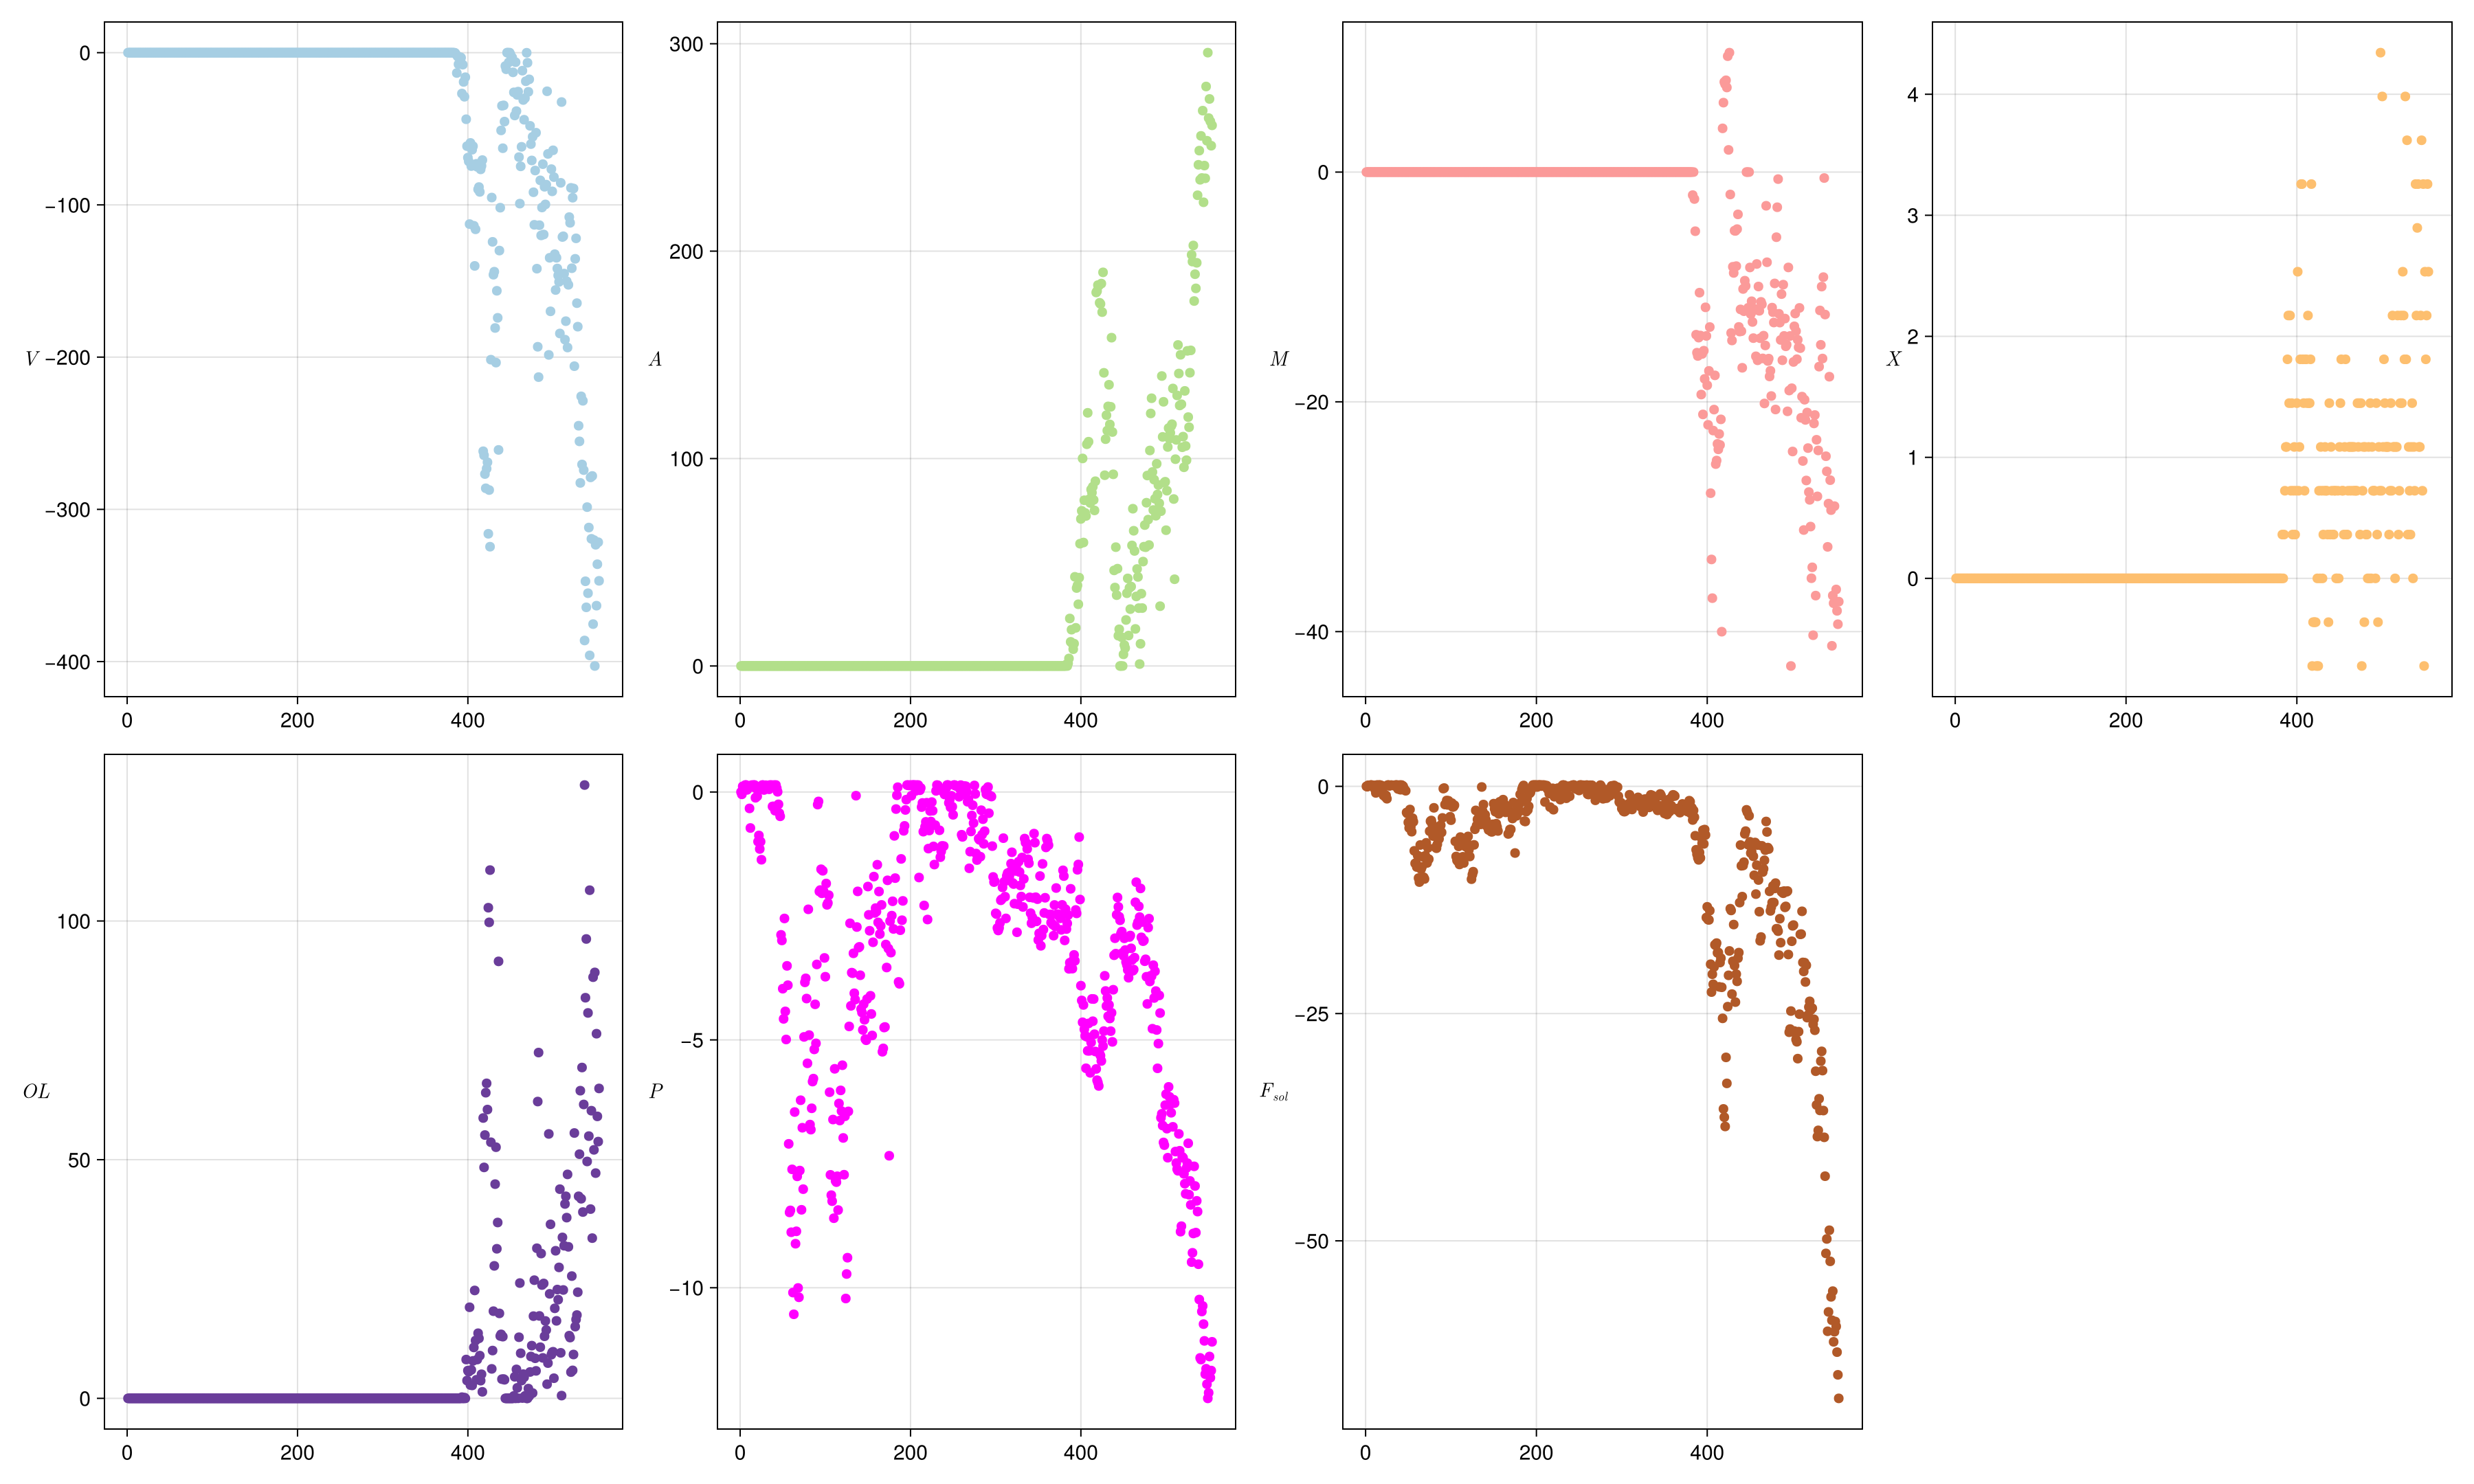

In [19]:
paired_colors = cgrad(:Paired_12, 12, categorical = true)
xs = 1:length(output.Es)

pf = MorphoMol.Energies.get_prefactors(1.4, 0.3665)

Vs = output.measures[1]
As = output.measures[2]
Ms = output.measures[3]
Xs = output.measures[4]
OLs = output.measures[5]
Ps = output.measures[6]
Es = output.Es

pt_per_in = 72
width =  5*5
height = 5*3
f_size = (pt_per_in * width, pt_per_in * height)
fs = 15
border_width = 0.5
fig = Figure(size = f_size, fontsize = fs)
ms = 10
scatter(fig[1, 1], xs, pf[1] .* (Vs .- Vs[1]), markersize = ms, color = paired_colors[1], axis = (ylabel = L"V", ylabelrotation = 0,))
scatter(fig[1, 2], xs, pf[2] .* (As .- As[1]), markersize = ms, color = paired_colors[3], axis = (ylabel = L"A", ylabelrotation = 0,))
scatter(fig[1, 3], xs, pf[3] .* (Ms .- Ms[1]), markersize = ms, color = paired_colors[5], axis = (ylabel = L"M", ylabelrotation = 0,))
scatter(fig[1, 4], xs, pf[4] .* (Xs .- Xs[1]), markersize = ms, color = paired_colors[7], axis = (ylabel = L"X", ylabelrotation = 0,))
scatter(fig[2, 1], xs, OLs .- OLs[1], markersize = ms, color = paired_colors[10], axis = (ylabel = L"OL", ylabelrotation = 0,))
scatter(fig[2, 2], xs, -0.1 * (Ps .- Ps[1]), markersize = ms, color = :magenta, axis = (ylabel = L"P", ylabelrotation = 0,))
scatter(fig[2, 3], xs, Es .- Es[1], markersize = ms, color = paired_colors[12], axis = (ylabel = L"F_{sol}", ylabelrotation = 0,))
fig
#save(string("$(save_dir)/rwm_output_plots.png"), fig, pt_per_unit = 1)

In [20]:
argmax(Ps)

549

In [21]:
rm("assets/output/persistence_testerino/polys/", recursive = true)
mkpath("assets/output/persistence_testerino/polys/")
radii = [input.template_radii; input.template_radii]
for (i, state) in enumerate(output.states)
    MorphoMol.Utilities.state_to_poly(MorphoMol.Utilities.get_flat_realization(state, input.template_mol), radii, "assets/output/persistence_testerino/polys/$(i)", input.number_of_molecules, length(input.template_radii))
end